In [1]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn import metrics

from dataset import get_dataset_class_number, get_num_samples
from utils import *

plt.style.use(['science', 'grid'])
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 11})


In [2]:
def read_data(data_path, method):
    results = []
    for name in os.listdir(data_path):
        path = os.path.join(data_path, name)
        if not os.path.isdir(path):
            continue
        if not os.path.isfile(os.path.join(path, 'results_recog.json')):
            continue
        with open(os.path.join(path, 'results_recog.json'), 'r') as f:
            res = json.load(f)
        with open(os.path.join(path, 'args.json'), 'r') as f:
            args = json.load(f)
        dic = res | args
        dic['path'] = path
        results.append(dic)
    df = pd.DataFrame(results)
    df = df.loc[(df['method'] == method) & (df['ghost_dataset_name'].isnull())]
    df = df[['S_seed', 'seed',
             'arch', 'num_samples', 'beta', 'lam', 'test_acc', 'test_bound', 'path']]

    df['test_bound'] = 0.01 * df['test_bound']
    df['test_error'] = 1 - df['test_acc'] * 0.01
    return df


def get_exp_res_dict(df):
    exp_res_dict = {
        "test_bound": {k: np.zeros([num_seeds]) for k in num_samples},
        "test_error": {k: np.zeros([num_seeds]) for k in num_samples},
        "fcmi": {k: np.zeros([num_seeds]) for k in num_samples},
        "recog": {k: {kk: None for kk in range(num_seeds)} for k in num_samples},
        "mask": {k: {kk: None for kk in range(num_seeds)} for k in num_samples}

    }
    for ns in num_samples:
        df_exp = df.loc[(df['num_samples'] == ns)]
        for j in range(num_seeds):
            df_exp_i = df_exp.loc[(df_exp['seed'] == j)]
            exp_res_dict['test_bound'][ns][j] = df_exp_i['test_bound'].mean()
            exp_res_dict['test_error'][ns][j] = df_exp_i['test_error'].mean()
            preds = []
            masks = []
            probs = []
            path_dict = df_exp_i[['path', 'S_seed']].set_index('S_seed')['path'].to_dict()
            for S_seed, path in path_dict.items():
                pred_dict = load_prediction('preds.pkl', path)
                preds.append(pred_dict['pred'])
                masks.append(pred_dict['mask'])
                probs.append(pred_dict['recog'])
            fcmi_bound = estimate_fcmi_bound(preds, masks, num_classes, ns)
            exp_res_dict['fcmi'][ns][j] = fcmi_bound
            exp_res_dict['recog'][ns][j] = probs
            exp_res_dict['mask'][ns][j] = masks

    return exp_res_dict


In [3]:
def plot_mean_std(ax, res_dict, key, label, marker):
    mean = np.array([np.mean((res_dict[key][ns])) for ns in num_samples])
    std = np.array([np.std((res_dict[key][ns])) for ns in num_samples])
    ax.plot(num_samples, mean, label=label, marker=marker, lw=2, markersize=8)
    ax.fill_between(num_samples, mean - std, mean + std, alpha=0.2)


def plot(exp_res_dicts, legend=True, ylabel=True):
    cmap = plt.get_cmap("tab10")
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.tick_params(labelsize=20)
    recog_dict = {k: np.zeros([num_seeds]) for k in num_samples}
    handlers = []
    for idx, ns in enumerate(num_samples):
        for i in range(num_seeds):
            recog = 0
            for j in range(num_S_seeds):
                fpr, tpr, _ = metrics.roc_curve(exp_res_dicts['mask'][ns][i][j], exp_res_dicts['recog'][ns][i][j])
                poly = patches.Polygon(xy=list(zip(fpr, tpr)) + list(zip(tpr[::-1], fpr[::-1])),
                                       fill=False, alpha=0.3, color=cmap(idx))
                ax.add_patch(poly)
                auc = metrics.roc_auc_score(exp_res_dicts['mask'][ns][i][j], exp_res_dicts['recog'][ns][i][j])
                recog += 1 - 2 * auc
            recog /= num_S_seeds
            recog_dict[ns][i] = recog
        handlers.append(poly)
    exp_res_dicts['recog_area'] = recog_dict
    ax.grid(False)
    if legend:
        ax.legend(handlers, [f'n={ns}' for ns in num_samples], fontsize=20, loc='lower right').get_frame().set_alpha(
            0.5)

    plt.show()

    fig, ax = plt.subplots(figsize=(6, 4))
    plot_mean_std(ax, exp_res_dicts, 'test_bound', 'gen. gap', 'o')
    plot_mean_std(ax, exp_res_dicts, 'test_error', 'test error', '^')
    plot_mean_std(ax, exp_res_dicts, 'fcmi', 'f-CMI bound', 'x')
    plot_mean_std(ax, exp_res_dicts, 'recog_area', 'recognizability', 's')

    ax.set_xlabel('n', size=26)
    if ylabel:
        ax.set_ylabel('Error', size=26)
    ax.tick_params(labelsize=24)
    ax.set_xscale('log', base=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(num_samples)
    if legend:
        ax.legend(fontsize=20, loc='upper right').get_frame().set_alpha(0.5)

    plt.show()


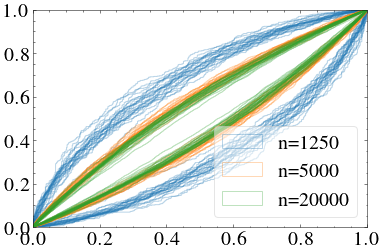

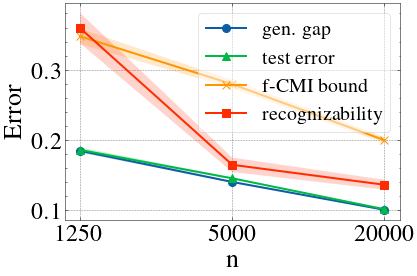

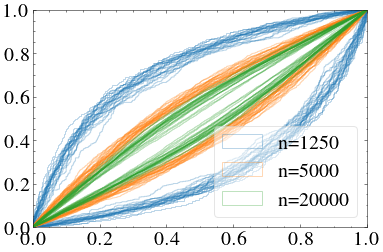

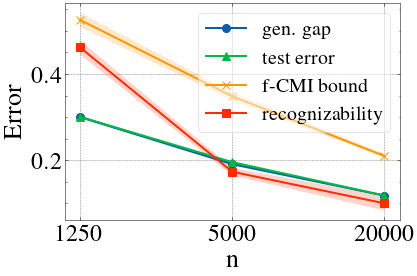

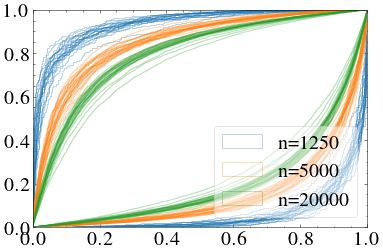

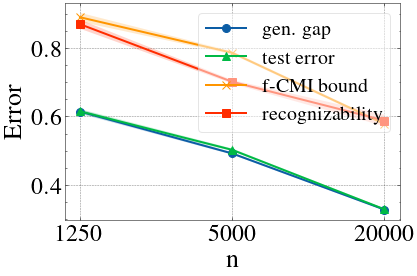

In [4]:
num_seeds = 5
num_S_seeds = 5
methods = ['vanilla']
logdir = '<your log dir>/my_cnn.CNN_my_mlp.MLP_seed_5_5_exp/'
datasets = ('fashion', 'svhn', 'cifar10')

ds_dict = {}
for dataset in datasets:
    num_classes = get_dataset_class_number(dataset)
    num_samples = get_num_samples(dataset)
    for method in methods:
        data_path = os.path.join(logdir, dataset)
        df = read_data(data_path, method)
        exp_res_dicts = get_exp_res_dict(df)
        plot(exp_res_dicts, True, True)
        ds_dict[method] = exp_res_dicts


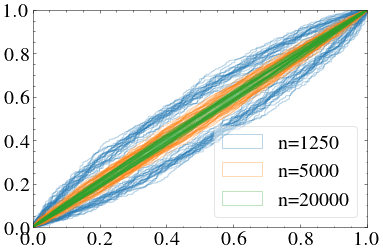

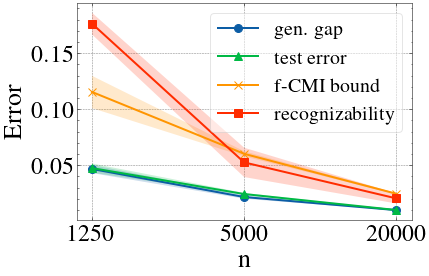

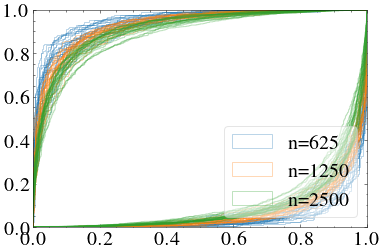

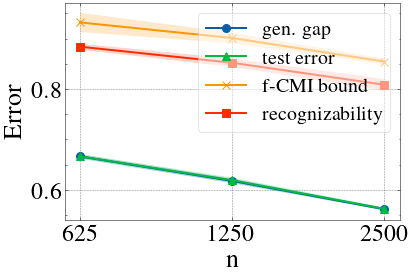

In [5]:
datasets = ('mnist', 'stl10')

ds_dict = {}
for dataset in datasets:
    num_classes = get_dataset_class_number(dataset)
    num_samples = get_num_samples(dataset)
    for method in methods:
        data_path = os.path.join(logdir, dataset)
        df = read_data(data_path, method)
        exp_res_dicts = get_exp_res_dict(df)
        plot(exp_res_dicts, True, True)
        ds_dict[method] = exp_res_dicts
